In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb 
# Size the plot appropriately for online display
plt.rcParams['figure.figsize'] = (12.0, 10.0)

In [2]:
types = {'StateHoliday': np.dtype(str)}
train = pd.read_csv("./assets/train_v2.csv", parse_dates=[2], nrows=66901, dtype=types)
store = pd.read_csv("./assets/store.csv")

In [3]:
not_open = train[(train['Open'] == 0) & (train['Sales'] != 0)]
print("No closed store with sales: " + str(not_open.size == 0))

No closed store with sales: True


In [4]:
no_sales = train[(train['Open'] == 1) & (train['Sales'] <= 0)]
print("No open store with no sales: " + str(no_sales.size == 0))

No open store with no sales: True


In [5]:
train = train.loc[train['Sales'] > 0]
assert(train[train['Sales'] == 0].size == 0)

In [6]:
dates = pd.to_datetime(train['Date'], format="%Y%m%d:%H:%M:%S.%f").sort_values()
dates = dates.unique()
start_date = dates[0]
end_date = dates[-1]
print("Start date: ", start_date)
print("End Date: ", end_date)
date_range = pd.date_range(start_date, end_date).values
assert(all(dates == date_range))

Start date:  2014-11-26T00:00:00.000000000
End Date:  2015-01-30T00:00:00.000000000


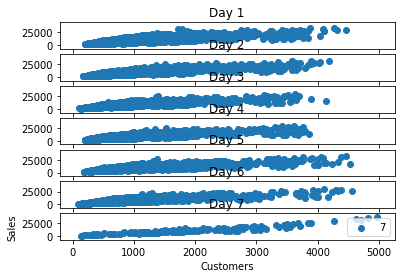

In [7]:
f, ax = plt.subplots(7, sharex=True, sharey=True)
for i in range(1, 8):
    mask = train[train['DayOfWeek'] == i]
    ax[i - 1].set_title("Day {0}".format(i))
    ax[i - 1].scatter(mask['Customers'], mask['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

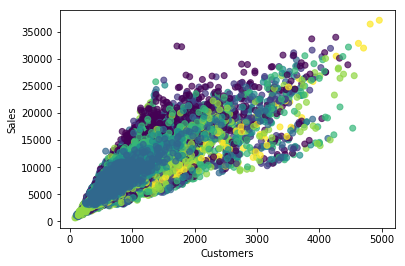

In [8]:
plt.scatter(train['Customers'], train['Sales'], c=train['DayOfWeek'], alpha=0.7, cmap=plt.cm.get_cmap('viridis'))

plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

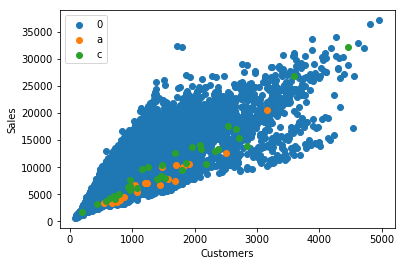

In [9]:
for i in ["0", "a", "b", "c"]:
    data = train[train['StateHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

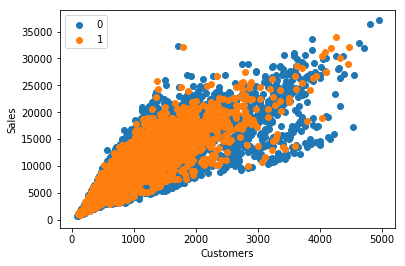

In [10]:
for i in [0, 1]:
    data = train[train['SchoolHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

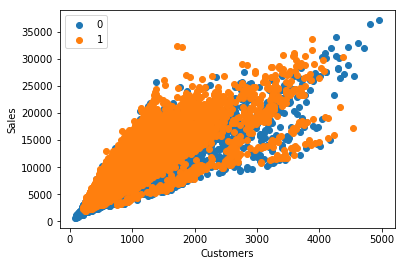

In [11]:
for i in [0, 1]:
    data = train[train['Promo'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

In [12]:
train['SalesPerCustomer'] = train['Sales'] / train['Customers']

avg_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].mean()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
store = pd.merge(avg_store.reset_index(), store, on='Store')
store.head()

,Store,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5574.037037,644.407407,8.574182,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5593.407407,602.833333,9.132443,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,7560.740741,797.296296,9.363221,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,10730.296296,1424.888889,7.481731,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5313.981481,564.833333,9.273212,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


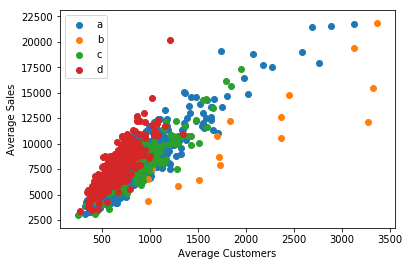

In [13]:
for i in ['a', 'b', 'c', 'd']:
    data = store[store['StoreType'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

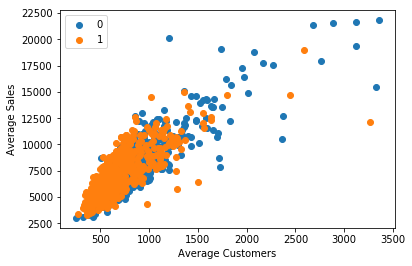

In [14]:
for i in [0, 1]:
    data = store[store['Promo2'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

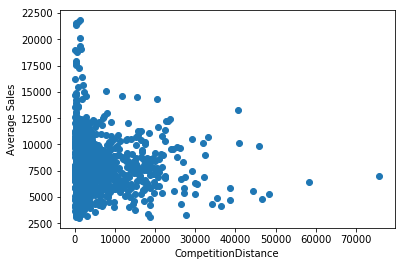

In [15]:
# fill NaN values
store["CompetitionDistance"].fillna(-1)
plt.scatter(store['CompetitionDistance'], store['AvgSales'])

plt.xlabel('CompetitionDistance')
plt.ylabel('Average Sales')
plt.show()

In [16]:
def build_features(train, store):
    # Convert string types into integers
    store['StoreType'] = store['StoreType'].astype('category').cat.codes
    store['Assortment'] = store['Assortment'].astype('category').cat.codes
    train["StateHoliday"] = train["StateHoliday"].astype('category').cat.codes

    merged = pd.merge(train, store, on='Store', how='left')
    
    # remove NaNs
    NaN_replace = 0
    merged.fillna(NaN_replace, inplace=True)
    
    merged['Year'] = merged.Date.dt.year
    merged['Month'] = merged.Date.dt.month
    merged['Day'] = merged.Date.dt.day
    merged['Week'] = merged.Date.dt.week
    
    # Number of months that competition has existed for
    merged['MonthsCompetitionOpen'] = \
        12 * (merged['Year'] - merged['CompetitionOpenSinceYear']) + \
        (merged['Month'] - merged['CompetitionOpenSinceMonth'])
    merged.loc[merged['CompetitionOpenSinceYear'] ==
               NaN_replace, 'MonthsCompetitionOpen'] = NaN_replace
    
    # Number of weeks that promotion has existed for
    merged['WeeksPromoOpen'] = \
        12 * (merged['Year'] - merged['Promo2SinceYear']) + \
        (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])
    merged.loc[merged['Promo2SinceYear'] == 
               NaN_replace, 'WeeksPromoOpen'] = NaN_replace

    toInt = [
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',
        'Promo2SinceWeek', 
        'Promo2SinceYear', 
        'MonthsCompetitionOpen', 
        'WeeksPromoOpen'
    ]
    merged[toInt] = merged[toInt].astype(int)

    return merged

med_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store = pd.merge(med_store.reset_index(), store, on='Store')
features = build_features(train, store)
features.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week,MonthsCompetitionOpen,WeeksPromoOpen
0,1,5,2015-01-30,5577,616,1,1,0,0,9.053571,...,0,0,0,0,2015,1,30,5,76,0
1,2,5,2015-01-30,5919,624,1,1,0,0,9.485577,...,1,13,2010,"Jan,Apr,Jul,Oct",2015,1,30,5,86,52
2,3,5,2015-01-30,6911,678,1,1,0,0,10.193215,...,1,14,2011,"Jan,Apr,Jul,Oct",2015,1,30,5,97,39
3,4,5,2015-01-30,13307,1632,1,1,0,0,8.153799,...,0,0,0,0,2015,1,30,5,64,0
4,5,5,2015-01-30,5640,617,1,1,0,0,9.141005,...,0,0,0,0,2015,1,30,5,-3,0


In [17]:
from sklearn.model_selection import train_test_split
X = [
    'Store', 
    'Customers',
    'CompetitionDistance', 

    'Promo', 
    'Promo2', 

#     'SchoolHoliday',
    'StateHoliday',
    'StoreType',
    'Assortment',

    'AvgSales',
    'AvgCustomers',
    'AvgSalesPerCustomer',
    
    'MedSales',
    'MedCustomers',
    'MedSalesPerCustomer',

    'DayOfWeek',
    'Week',
    'Day',
    'Month',
    'Year',

    'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2SinceWeek',
    'Promo2SinceYear',

#     'MonthsCompetitionOpen',
#     'WeeksPromoOpen'
]
X_train, X_test, y_train, y_test = train_test_split(
    features[X], features['Sales'], test_size=0.15, random_state=10)

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Error calculating function according to kaggle
def rmspe(y, y_hat):
    return np.sqrt(np.mean(((y - y_hat) / y) ** 2))

rmpse_scorer = make_scorer(rmspe, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, y_hat))

def plot_importance(model):
    k = list(zip(X, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    
    plt.barh(np.arange(len(X)), vals, align='center')
    plt.yticks(np.arange(len(X)), labels)

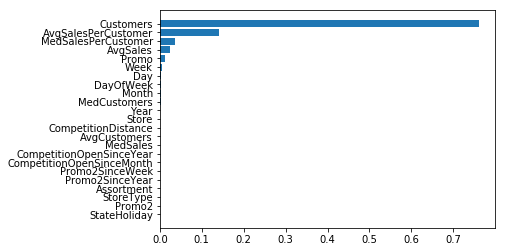

In [19]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
plot_importance(decision_tree)

In [20]:
y_hat = decision_tree.predict(X_test)
score(decision_tree, X_train, y_train, y_test, y_hat)

Mean -0.08495412673313536
Variance 1.0085923035949457e-06
RMSPE 0.08272473644632616


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.3s finished


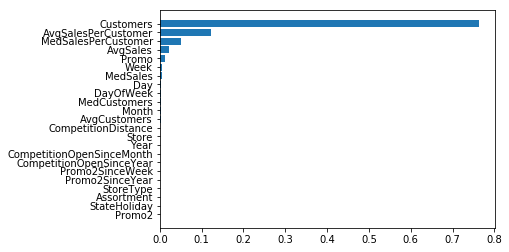

In [21]:
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators=25, n_jobs=-1, verbose=1)
randomForest.fit(X_train, y_train)
plot_importance(randomForest)

In [22]:
y_hat = randomForest.predict(X_test)
score(randomForest, X_train, y_train, y_test, y_hat)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  2

Mean -0.06080980622779072
Variance 5.458489031870373e-07
RMSPE 0.059600547682879826


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


In [23]:
import xgboost as xgb

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

xgboost_tree = xgb.XGBRegressor(
    n_jobs = -1,
    n_estimators = 1000,
    eta = 0.1,
    max_depth = 2,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.05,
    silent = 0,
    random_state = 1023
)
xgboost_tree.fit(X_train[X], np.log1p(y_train), 
                 eval_set = [(X_train[X], np.log1p(y_train)), (X_test[X], np.log1p(y_test))],
                 eval_metric = rmspe_xg,
                 early_stopping_rounds = 300
                )

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:12:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.53663	validation_1-rmse:7.53603	validation_0-rmspe:0.999568	validation_1-rmspe:0.99957
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 300 rounds.
[1]	validation_0-rmse:6.78395	validation_1-rmse:6.78346	validation_0-rmspe:0.998921	validation_1-rmspe:0.998924
[2]	validation_0-rmse:6.10655	validation_1-rmse:6.10602	validation_0-rmspe:0.997745	validation_1-rmspe:0.99775
[3]	validation_0-rmse:5.49703	validation_1-rmse:5.49642	validation_0-rmspe:0.995754	validation_1-rmspe:0.995762
[4]	validation_0-rmse:4.94849	validation_1-rmse:4.94778	validation_0-rmspe:0.992582	validation_1-rmspe:0.992594
[5]	validation_0-rmse:4.45482	validation_1-rmse:4.454	validation_0-rmspe:0.987813	validation_1-rmspe:0.987829
[6]	va

[70]	validation_0-rmse:0.087635	validation_1-rmse:0.087087	validation_0-rmspe:0.088352	validation_1-rmspe:0.087074
[71]	validation_0-rmse:0.087031	validation_1-rmse:0.086454	validation_0-rmspe:0.087834	validation_1-rmspe:0.086516
[72]	validation_0-rmse:0.086312	validation_1-rmse:0.085724	validation_0-rmspe:0.087183	validation_1-rmspe:0.085833
[73]	validation_0-rmse:0.085683	validation_1-rmse:0.085138	validation_0-rmspe:0.086469	validation_1-rmspe:0.085255
[74]	validation_0-rmse:0.085093	validation_1-rmse:0.084632	validation_0-rmspe:0.085789	validation_1-rmspe:0.084699
[75]	validation_0-rmse:0.084479	validation_1-rmse:0.084026	validation_0-rmspe:0.085273	validation_1-rmspe:0.084193
[76]	validation_0-rmse:0.083837	validation_1-rmse:0.083322	validation_0-rmspe:0.08465	validation_1-rmspe:0.083497
[77]	validation_0-rmse:0.083379	validation_1-rmse:0.082911	validation_0-rmspe:0.083984	validation_1-rmspe:0.082973
[78]	validation_0-rmse:0.082777	validation_1-rmse:0.082315	validation_0-rmspe:0.0

[142]	validation_0-rmse:0.067001	validation_1-rmse:0.066761	validation_0-rmspe:0.06722	validation_1-rmspe:0.066728
[143]	validation_0-rmse:0.066926	validation_1-rmse:0.066682	validation_0-rmspe:0.067149	validation_1-rmspe:0.066651
[144]	validation_0-rmse:0.066824	validation_1-rmse:0.066561	validation_0-rmspe:0.067039	validation_1-rmspe:0.06652
[145]	validation_0-rmse:0.066737	validation_1-rmse:0.066488	validation_0-rmspe:0.066929	validation_1-rmspe:0.066442
[146]	validation_0-rmse:0.066571	validation_1-rmse:0.066335	validation_0-rmspe:0.066763	validation_1-rmspe:0.06629
[147]	validation_0-rmse:0.066427	validation_1-rmse:0.066207	validation_0-rmspe:0.066615	validation_1-rmspe:0.066157
[148]	validation_0-rmse:0.06632	validation_1-rmse:0.066109	validation_0-rmspe:0.066519	validation_1-rmspe:0.066068
[149]	validation_0-rmse:0.066163	validation_1-rmse:0.065944	validation_0-rmspe:0.066367	validation_1-rmspe:0.065907
[150]	validation_0-rmse:0.066077	validation_1-rmse:0.065837	validation_0-rms

[213]	validation_0-rmse:0.061404	validation_1-rmse:0.061249	validation_0-rmspe:0.061491	validation_1-rmspe:0.061125
[214]	validation_0-rmse:0.061374	validation_1-rmse:0.061221	validation_0-rmspe:0.061456	validation_1-rmspe:0.061099
[215]	validation_0-rmse:0.06132	validation_1-rmse:0.061169	validation_0-rmspe:0.061402	validation_1-rmspe:0.061048
[216]	validation_0-rmse:0.061287	validation_1-rmse:0.061152	validation_0-rmspe:0.061362	validation_1-rmspe:0.061029
[217]	validation_0-rmse:0.06125	validation_1-rmse:0.061112	validation_0-rmspe:0.061332	validation_1-rmspe:0.060996
[218]	validation_0-rmse:0.061206	validation_1-rmse:0.061068	validation_0-rmspe:0.061288	validation_1-rmspe:0.060951
[219]	validation_0-rmse:0.061165	validation_1-rmse:0.061023	validation_0-rmspe:0.061247	validation_1-rmspe:0.060906
[220]	validation_0-rmse:0.061111	validation_1-rmse:0.060975	validation_0-rmspe:0.061196	validation_1-rmspe:0.060858
[221]	validation_0-rmse:0.06106	validation_1-rmse:0.060915	validation_0-rm

[284]	validation_0-rmse:0.058981	validation_1-rmse:0.05891	validation_0-rmspe:0.059006	validation_1-rmspe:0.058759
[285]	validation_0-rmse:0.058948	validation_1-rmse:0.058871	validation_0-rmspe:0.058974	validation_1-rmspe:0.058722
[286]	validation_0-rmse:0.058928	validation_1-rmse:0.058854	validation_0-rmspe:0.058954	validation_1-rmspe:0.058707
[287]	validation_0-rmse:0.058913	validation_1-rmse:0.058837	validation_0-rmspe:0.058943	validation_1-rmspe:0.058695
[288]	validation_0-rmse:0.058896	validation_1-rmse:0.05882	validation_0-rmspe:0.058928	validation_1-rmspe:0.058678
[289]	validation_0-rmse:0.058885	validation_1-rmse:0.058807	validation_0-rmspe:0.058915	validation_1-rmspe:0.058664
[290]	validation_0-rmse:0.058865	validation_1-rmse:0.058784	validation_0-rmspe:0.058898	validation_1-rmspe:0.058644
[291]	validation_0-rmse:0.058854	validation_1-rmse:0.05878	validation_0-rmspe:0.058889	validation_1-rmspe:0.058644
[292]	validation_0-rmse:0.058808	validation_1-rmse:0.058741	validation_0-rm

[355]	validation_0-rmse:0.057662	validation_1-rmse:0.057684	validation_0-rmspe:0.057664	validation_1-rmspe:0.05754
[356]	validation_0-rmse:0.057649	validation_1-rmse:0.057673	validation_0-rmspe:0.057649	validation_1-rmspe:0.05753
[357]	validation_0-rmse:0.05764	validation_1-rmse:0.057663	validation_0-rmspe:0.057643	validation_1-rmspe:0.057522
[358]	validation_0-rmse:0.057624	validation_1-rmse:0.057636	validation_0-rmspe:0.057628	validation_1-rmspe:0.057496
[359]	validation_0-rmse:0.057607	validation_1-rmse:0.05763	validation_0-rmspe:0.057608	validation_1-rmspe:0.057488
[360]	validation_0-rmse:0.057595	validation_1-rmse:0.057619	validation_0-rmspe:0.057595	validation_1-rmspe:0.057476
[361]	validation_0-rmse:0.057584	validation_1-rmse:0.057603	validation_0-rmspe:0.057587	validation_1-rmspe:0.057463
[362]	validation_0-rmse:0.057569	validation_1-rmse:0.057582	validation_0-rmspe:0.057571	validation_1-rmspe:0.057441
[363]	validation_0-rmse:0.057557	validation_1-rmse:0.057574	validation_0-rms

[426]	validation_0-rmse:0.056759	validation_1-rmse:0.056822	validation_0-rmspe:0.056766	validation_1-rmspe:0.056692
[427]	validation_0-rmse:0.056741	validation_1-rmse:0.056803	validation_0-rmspe:0.056751	validation_1-rmspe:0.056678
[428]	validation_0-rmse:0.056736	validation_1-rmse:0.0568	validation_0-rmspe:0.056745	validation_1-rmspe:0.056673
[429]	validation_0-rmse:0.056728	validation_1-rmse:0.056796	validation_0-rmspe:0.056737	validation_1-rmspe:0.05667
[430]	validation_0-rmse:0.056723	validation_1-rmse:0.056794	validation_0-rmspe:0.056732	validation_1-rmspe:0.056669
[431]	validation_0-rmse:0.056711	validation_1-rmse:0.056782	validation_0-rmspe:0.05672	validation_1-rmspe:0.056657
[432]	validation_0-rmse:0.056705	validation_1-rmse:0.056779	validation_0-rmspe:0.056713	validation_1-rmspe:0.056652
[433]	validation_0-rmse:0.056694	validation_1-rmse:0.056771	validation_0-rmspe:0.056699	validation_1-rmspe:0.056643
[434]	validation_0-rmse:0.056683	validation_1-rmse:0.056766	validation_0-rms

[497]	validation_0-rmse:0.056205	validation_1-rmse:0.056354	validation_0-rmspe:0.056195	validation_1-rmspe:0.056222
[498]	validation_0-rmse:0.056191	validation_1-rmse:0.056343	validation_0-rmspe:0.056181	validation_1-rmspe:0.056212
[499]	validation_0-rmse:0.056183	validation_1-rmse:0.056335	validation_0-rmspe:0.056173	validation_1-rmspe:0.056204
[500]	validation_0-rmse:0.056175	validation_1-rmse:0.056332	validation_0-rmspe:0.056164	validation_1-rmspe:0.056199
[501]	validation_0-rmse:0.056169	validation_1-rmse:0.056329	validation_0-rmspe:0.056159	validation_1-rmspe:0.056197
[502]	validation_0-rmse:0.056164	validation_1-rmse:0.056322	validation_0-rmspe:0.056155	validation_1-rmspe:0.056192
[503]	validation_0-rmse:0.056156	validation_1-rmse:0.056314	validation_0-rmspe:0.056147	validation_1-rmspe:0.056185
[504]	validation_0-rmse:0.056153	validation_1-rmse:0.056313	validation_0-rmspe:0.056145	validation_1-rmspe:0.056184
[505]	validation_0-rmse:0.056143	validation_1-rmse:0.056301	validation_0

[568]	validation_0-rmse:0.055725	validation_1-rmse:0.055952	validation_0-rmspe:0.055706	validation_1-rmspe:0.055809
[569]	validation_0-rmse:0.055721	validation_1-rmse:0.055944	validation_0-rmspe:0.055702	validation_1-rmspe:0.055803
[570]	validation_0-rmse:0.055701	validation_1-rmse:0.055932	validation_0-rmspe:0.055681	validation_1-rmspe:0.055789
[571]	validation_0-rmse:0.055695	validation_1-rmse:0.055933	validation_0-rmspe:0.055675	validation_1-rmspe:0.05579
[572]	validation_0-rmse:0.055689	validation_1-rmse:0.055927	validation_0-rmspe:0.055669	validation_1-rmspe:0.055785
[573]	validation_0-rmse:0.055683	validation_1-rmse:0.055923	validation_0-rmspe:0.055663	validation_1-rmspe:0.055781
[574]	validation_0-rmse:0.055679	validation_1-rmse:0.055915	validation_0-rmspe:0.055657	validation_1-rmspe:0.055773
[575]	validation_0-rmse:0.055676	validation_1-rmse:0.055913	validation_0-rmspe:0.055655	validation_1-rmspe:0.05577
[576]	validation_0-rmse:0.055673	validation_1-rmse:0.055905	validation_0-r

[639]	validation_0-rmse:0.055312	validation_1-rmse:0.055538	validation_0-rmspe:0.055294	validation_1-rmspe:0.055406
[640]	validation_0-rmse:0.055305	validation_1-rmse:0.055534	validation_0-rmspe:0.055287	validation_1-rmspe:0.055401
[641]	validation_0-rmse:0.055302	validation_1-rmse:0.05553	validation_0-rmspe:0.055283	validation_1-rmspe:0.055396
[642]	validation_0-rmse:0.055297	validation_1-rmse:0.055528	validation_0-rmspe:0.055277	validation_1-rmspe:0.055394
[643]	validation_0-rmse:0.055293	validation_1-rmse:0.055525	validation_0-rmspe:0.055274	validation_1-rmspe:0.055392
[644]	validation_0-rmse:0.055288	validation_1-rmse:0.055523	validation_0-rmspe:0.055269	validation_1-rmspe:0.05539
[645]	validation_0-rmse:0.055286	validation_1-rmse:0.055521	validation_0-rmspe:0.055268	validation_1-rmspe:0.05539
[646]	validation_0-rmse:0.05528	validation_1-rmse:0.05552	validation_0-rmspe:0.055264	validation_1-rmspe:0.05539
[647]	validation_0-rmse:0.055275	validation_1-rmse:0.055518	validation_0-rmspe

[710]	validation_0-rmse:0.055012	validation_1-rmse:0.055305	validation_0-rmspe:0.054992	validation_1-rmspe:0.055171
[711]	validation_0-rmse:0.05501	validation_1-rmse:0.055304	validation_0-rmspe:0.054989	validation_1-rmspe:0.055169
[712]	validation_0-rmse:0.055003	validation_1-rmse:0.055295	validation_0-rmspe:0.054982	validation_1-rmspe:0.055159
[713]	validation_0-rmse:0.055001	validation_1-rmse:0.055291	validation_0-rmspe:0.054979	validation_1-rmspe:0.055154
[714]	validation_0-rmse:0.054996	validation_1-rmse:0.05529	validation_0-rmspe:0.054975	validation_1-rmspe:0.055154
[715]	validation_0-rmse:0.054994	validation_1-rmse:0.055289	validation_0-rmspe:0.054974	validation_1-rmspe:0.055154
[716]	validation_0-rmse:0.054992	validation_1-rmse:0.055286	validation_0-rmspe:0.054971	validation_1-rmspe:0.055151
[717]	validation_0-rmse:0.05499	validation_1-rmse:0.055288	validation_0-rmspe:0.05497	validation_1-rmspe:0.055154
[718]	validation_0-rmse:0.054984	validation_1-rmse:0.055284	validation_0-rms

[781]	validation_0-rmse:0.05475	validation_1-rmse:0.055078	validation_0-rmspe:0.054726	validation_1-rmspe:0.054944
[782]	validation_0-rmse:0.054748	validation_1-rmse:0.055078	validation_0-rmspe:0.054723	validation_1-rmspe:0.054943
[783]	validation_0-rmse:0.054744	validation_1-rmse:0.055077	validation_0-rmspe:0.05472	validation_1-rmspe:0.054943
[784]	validation_0-rmse:0.05474	validation_1-rmse:0.055071	validation_0-rmspe:0.054715	validation_1-rmspe:0.054935
[785]	validation_0-rmse:0.054738	validation_1-rmse:0.055069	validation_0-rmspe:0.054715	validation_1-rmspe:0.054936
[786]	validation_0-rmse:0.054735	validation_1-rmse:0.055064	validation_0-rmspe:0.054714	validation_1-rmspe:0.054933
[787]	validation_0-rmse:0.054734	validation_1-rmse:0.055064	validation_0-rmspe:0.054711	validation_1-rmspe:0.054931
[788]	validation_0-rmse:0.054728	validation_1-rmse:0.05506	validation_0-rmspe:0.054704	validation_1-rmspe:0.054926
[789]	validation_0-rmse:0.054726	validation_1-rmse:0.055058	validation_0-rms

[852]	validation_0-rmse:0.054474	validation_1-rmse:0.054836	validation_0-rmspe:0.054447	validation_1-rmspe:0.054703
[853]	validation_0-rmse:0.054471	validation_1-rmse:0.054834	validation_0-rmspe:0.054445	validation_1-rmspe:0.054702
[854]	validation_0-rmse:0.054469	validation_1-rmse:0.054833	validation_0-rmspe:0.05444	validation_1-rmspe:0.054698
[855]	validation_0-rmse:0.054468	validation_1-rmse:0.054832	validation_0-rmspe:0.054437	validation_1-rmspe:0.054696
[856]	validation_0-rmse:0.054464	validation_1-rmse:0.054828	validation_0-rmspe:0.054434	validation_1-rmspe:0.054692
[857]	validation_0-rmse:0.05446	validation_1-rmse:0.054824	validation_0-rmspe:0.054429	validation_1-rmspe:0.054685
[858]	validation_0-rmse:0.054458	validation_1-rmse:0.054822	validation_0-rmspe:0.054429	validation_1-rmspe:0.054686
[859]	validation_0-rmse:0.054455	validation_1-rmse:0.054816	validation_0-rmspe:0.054427	validation_1-rmspe:0.054682
[860]	validation_0-rmse:0.054453	validation_1-rmse:0.054819	validation_0-r

[923]	validation_0-rmse:0.054193	validation_1-rmse:0.054613	validation_0-rmspe:0.054165	validation_1-rmspe:0.054475
[924]	validation_0-rmse:0.05419	validation_1-rmse:0.054611	validation_0-rmspe:0.054161	validation_1-rmspe:0.054473
[925]	validation_0-rmse:0.054186	validation_1-rmse:0.05461	validation_0-rmspe:0.054156	validation_1-rmspe:0.054471
[926]	validation_0-rmse:0.054184	validation_1-rmse:0.054609	validation_0-rmspe:0.054152	validation_1-rmspe:0.054469
[927]	validation_0-rmse:0.054182	validation_1-rmse:0.054608	validation_0-rmspe:0.05415	validation_1-rmspe:0.054468
[928]	validation_0-rmse:0.05418	validation_1-rmse:0.054605	validation_0-rmspe:0.054148	validation_1-rmspe:0.054465
[929]	validation_0-rmse:0.054176	validation_1-rmse:0.0546	validation_0-rmspe:0.054142	validation_1-rmspe:0.054459
[930]	validation_0-rmse:0.054174	validation_1-rmse:0.054599	validation_0-rmspe:0.054144	validation_1-rmspe:0.05446
[931]	validation_0-rmse:0.054172	validation_1-rmse:0.054598	validation_0-rmspe:

[994]	validation_0-rmse:0.053952	validation_1-rmse:0.054422	validation_0-rmspe:0.053924	validation_1-rmspe:0.054282
[995]	validation_0-rmse:0.05395	validation_1-rmse:0.054423	validation_0-rmspe:0.053921	validation_1-rmspe:0.054282
[996]	validation_0-rmse:0.053949	validation_1-rmse:0.054421	validation_0-rmspe:0.05392	validation_1-rmspe:0.05428
[997]	validation_0-rmse:0.053944	validation_1-rmse:0.054416	validation_0-rmspe:0.053915	validation_1-rmspe:0.054274
[998]	validation_0-rmse:0.053941	validation_1-rmse:0.054416	validation_0-rmspe:0.053913	validation_1-rmspe:0.054276
[999]	validation_0-rmse:0.05394	validation_1-rmse:0.054418	validation_0-rmspe:0.053913	validation_1-rmspe:0.054279


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=2, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=1023,
       reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=0, subsample=0.8, tree_method='exact', verbosity=1)

Note that this is not in percentage, thus not to scale of graphs above


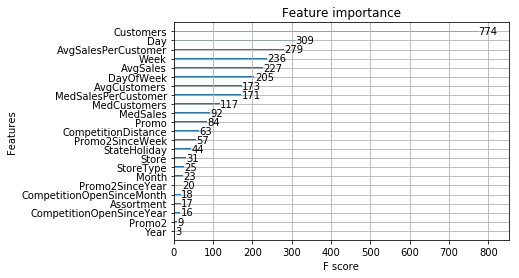

In [24]:
print("Note that this is not in percentage, thus not to scale of graphs above")
xgb.plot_importance(xgboost_tree)

In [25]:
def rmspe_exp(y, y_hat):
    return rmspe(np.expm1(y), np.expm1(y_hat))

rmpse_xg_scorer = make_scorer(rmspe_exp, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_xg_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, np.expm1(y_hat)))

y_hat = xgboost_tree.predict(X_test[X])
score(xgboost_tree, X_train[X], np.log1p(y_train), y_test, y_hat)

[21:33:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:33:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:34:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:35:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean -0.05545218890918977
Variance 2.1567442008742737e-07
RMSPE 0.054274273124918476


In [28]:
test = pd.read_csv("./assets/test_v2.csv", parse_dates=[2], dtype=types)
features = build_features(test, store)

y_hat = np.expm1(xgboost_tree.predict(features[X]))

df = pd.DataFrame({"Id": range(1, len(test) + 1), 'Sales': y_hat})
df.loc[test['Open'] == 0, 'Sales'] = 1
df.to_csv('sales.csv', index=False)